In [14]:
import random
from tqdm import tqdm
import copy

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tictactoe import TicTacToe

# Часть 1. Q-обучение

## 1.1 Учим 3х3 таблично

In [2]:
def get_action(env, Q, epsilon=0.1):
    state, empty_states, _ = env.getState()
    move = np.random.choice(len(empty_states))
    if state in Q:
        if random.random() > epsilon:
            move = np.argmax(Q[state])
    else:
        Q[state] = np.zeros(len(empty_states))
    
    action = empty_states[move]                        
    return move, action

In [3]:
def train(env, Q_X, Q_O, alpha=1e-3, epsilon=0.1, gamma=1):
    env.reset()  
    state, empty_states, cur_turn = env.getState()
    X_s, X_a = None, None
    O_s, O_a = None, None
    done = False
    while not done:
        state, empty_states, cur_turn = env.getState()
        if cur_turn == 1:
            move, action = get_action(env, Q_X, epsilon)
            new_state, reward, done, _ = env.step(action)
            
            if reward == 1:
                Q_X[state][move] = 1
            if O_s:
                Q_O[O_s][O_a] += alpha * (-reward + gamma * np.max(Q_O.get(new_state[0], 0)) - Q_O[O_s][O_a])
            X_s, X_a = state, move
        
        elif cur_turn == -1:
            move, action = get_action(env, Q_O, epsilon)
            new_state, reward, done, _ = env.step(action)
            
            if reward == -1:
                Q_O[state][move] = 1
                
            if X_s:
                Q_X[X_s][X_a] += alpha * (reward + gamma * np.max(Q_X.get(new_state[0], 0)) - Q_X[X_s][X_a])
            O_s, O_a = state, move

In [4]:
def play_one_game(Q, env, X_flag=True):
    env.reset()
    state, empty_states, _ = env.getState()
    done = False
    if not X_flag:
        move, action = get_action(env, dict(), epsilon=1)
        (state, empty_states, cur_turn), reward, done, _ = env.step(action)

    while not done:
        move, action = get_action(env, Q, epsilon=0)
        (state, empty_states, cur_turn), reward, done, _ = env.step(action) 
        
        if done:
            break
        
        move, action = get_action(env, dict(), epsilon=1)
        (state, empty_states, cur_turn), reward, done, _ = env.step(action) 
    
    if X_flag:
        return reward
    return -reward

In [5]:
def test_policy(Q, env, num_plays=500, X_flag=True):
    output = []
    for _ in range(num_plays):
        output.append(play_one_game(Q, env, X_flag))
    return np.mean(output)

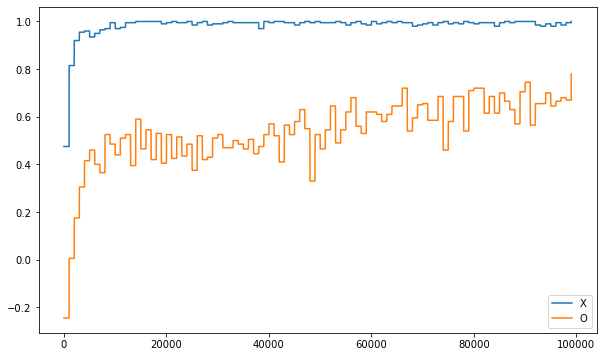

In [124]:
Q_X = {}
Q_O = {}

env = TicTacToe(3, 3, 3)
learning_episodes = 100000
num_plays = 200
X_results = []
O_results = []
for i in range(learning_episodes):
    train(env, Q_X, Q_O, alpha=0.01, epsilon=0.2)
    if i % 1000 == 0:
        X_results.append(test_policy(Q_X, env, num_plays=num_plays))
        O_results.append(test_policy(Q_O, env, num_plays=num_plays, X_flag=False))
        plt.figure(figsize=(10, 6))
        plt.plot(X_results, label='X')
        plt.plot(O_results, label='O')
        plt.legend()
        plt.show()
        clear_output(wait=True)
    else:
        X_results.append(X_results[-1])
        O_results.append(O_results[-1])

## Пункт 2. Пробуем на 4х4 и 5х5

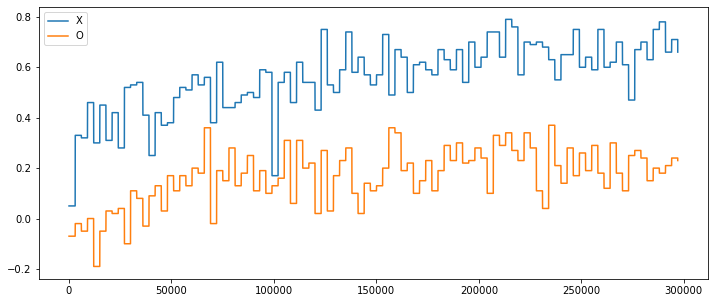

In [140]:
Q_X = {}
Q_O = {}

env = TicTacToe(4, 4, 4)
learning_episodes = 300000
num_plays = 100
X_results = []
O_results = []
for i in range(learning_episodes):
    train(env, Q_X, Q_O, alpha=0.005, epsilon=0.3)
    if i % (learning_episodes / 100) == 0:
        X_results.append(test_policy(Q_X, env, num_plays=num_plays))
        O_results.append(test_policy(Q_O, env, num_plays=num_plays, X_flag=False))
        plt.figure(figsize=(12, 5))
        plt.plot(X_results, label='X')
        plt.plot(O_results, label='O')
        plt.legend()
        plt.show()
        clear_output(wait=True)
    else:
        X_results.append(X_results[-1])
        O_results.append(O_results[-1])

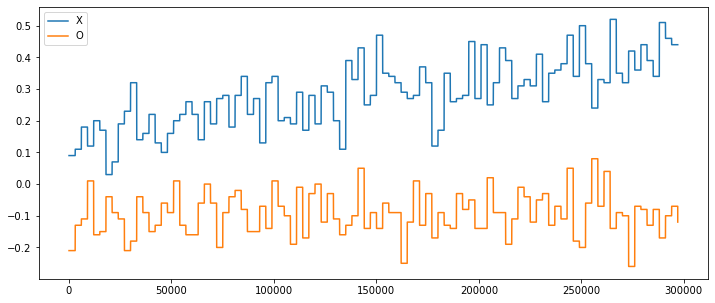

In [143]:
Q_X = {}
Q_O = {}

env = TicTacToe(5, 5, 5)
learning_episodes = 300000
num_plays = 100
X_results = []
O_results = []
for i in range(learning_episodes):
    train(env, Q_X, Q_O, alpha=0.005, epsilon=0.2)
    if i % (learning_episodes / 100) == 0:
        X_results.append(test_policy(Q_X, env, num_plays=num_plays))
        O_results.append(test_policy(Q_O, env, num_plays=num_plays, X_flag=False))
        plt.figure(figsize=(12, 5))
        plt.plot(X_results, label='X')
        plt.plot(O_results, label='O')
        plt.legend()
        plt.show()
        clear_output(wait=True)
    else:
        X_results.append(X_results[-1])
        O_results.append(O_results[-1])

В целом модели обучаются, остается лишь подтюнить параметры. Можно сказать, что все работает, поэтому идем дальше.

# Часть 2. Нейросеточки

# Пункт 3. DQN

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [7]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = random.sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]
    
    def __len__(self):
        return self.size

In [8]:
class DQN(nn.Module):
    def __init__(self, field_size=(3, 3), layer_size=512, hidden_dim=512):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=layer_size, kernel_size=field_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(layer_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, field_size[0] * field_size[1])
        ) 
        
    def forward(self, x):
        output = self.model(x)
        return output

In [9]:
def state_to_torch(state):
    return torch.FloatTensor(np.array([(state == 1), (state == -1), (state == 0)]))

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
from torch.autograd import Variable
import math

class TicTacToeDQN():
    def __init__(self, n_rows=3, n_cols=3, n_win=3, net=DQN, lr=3e-4, gamma=1, epsilon=0.9, buffer_size=1000000):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.env = TicTacToe(n_rows, n_cols, n_win)
        
        self.model_O = net(field_size=(n_rows, n_cols))
        self.model_X = net(field_size=(n_rows, n_cols))
        self.memory_X = ReplayMemory(buffer_size)
        self.memory_O = ReplayMemory(buffer_size)
        self.model_O.to(device)
        self.model_X.to(device)
        self.optimizer_X = torch.optim.Adam(self.model_X.parameters(), lr=lr, weight_decay=1e-6)
        self.optimizer_O = torch.optim.Adam(self.model_O.parameters(), lr=lr, weight_decay=1e-6)
        
        self.prev_actions={}
        self.prev_states={-1:None,1:None}
        self.gamma = gamma
        self.batch_size = 256
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 100000
        self.num_step = 0

    def select_action(self, state, cur_turn):
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if random.random() > eps_threshold:
            return self.select_greedy_action(state, cur_turn)
        else:
            return torch.tensor([[random.randrange(self.n_rows * self.n_cols)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        state, _, cur_turn = self.env.getState()
        prev_actions = {}
        prev_states = {-1: None, 1: None}

        done = False
        while not done:
            state_tensor = self.reshape_state(self.env.board).to(device)
            
            with torch.no_grad():
                if greedy:
                    int_act = self.select_greedy_action(state_tensor, cur_turn).to(device)
                else:
                    int_act = self.select_action(state_tensor, cur_turn).to(device)

            self.prev_states[cur_turn] = state_tensor
            self.prev_actions[cur_turn] = int_act
            action = self.env.action_from_int(torch.tensor(int_act.item()))
            next_state, reward, done, _ = self.env.step(action)
            next_state, emptySpaces, cur_turn = next_state
            next_state_tensor = self.reshape_state(self.env.board)

            if reward == -10:
                transition = (state_tensor, int_act, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                self.select_mem(cur_turn).append(transition)
            else:
                if reward == -cur_turn:
                    transition = (self.prev_states[-cur_turn], self.prev_actions[-cur_turn], next_state_tensor, torch.tensor([1], dtype=torch.float32))
                    self.select_mem(-cur_turn).append(transition)
                        
                if self.prev_states[cur_turn] is not None:        
                    transition = (self.prev_states[cur_turn], self.prev_actions[cur_turn], next_state_tensor, torch.tensor([reward * cur_turn], dtype=torch.float32))
                    self.select_mem(cur_turn).append(transition)

            if do_learning:
                self.learn(cur_turn)

            state = next_state
            self.num_step += 1
            
    def learn(self, cur_turn):
        if len(self.select_mem(cur_turn)) < self.batch_size:
            return
        
        transitions = self.select_mem(cur_turn).sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        
        batch_state = Variable(torch.stack(batch_state)).to(device)
        batch_action = Variable(torch.cat(batch_action)).to(device)
        batch_reward = Variable(torch.cat(batch_reward)).to(device)
        batch_next_state = Variable(torch.stack(batch_next_state)).to(device)

        Q = self.select_model(cur_turn)(batch_state.to(device)).gather(1, batch_action).reshape([self.batch_size])
        
        Qmax = self.select_model(cur_turn)(batch_next_state.to(device)).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        loss = F.smooth_l1_loss(Q, Qnext)
        self.select_optim(cur_turn).zero_grad()
        loss.backward()
        self.select_optim(cur_turn).step()
        
    def playDQN(self, side, play_episodes=500):
        rewards = []
        for i in range(play_episodes):
            self.env.reset()
            state, emptySpaces, cur_turn = self.env.getState()
            done = False
            while not done:
                if cur_turn == side:
                    int_act = self.select_greedy_action(self.reshape_state(self.env.board), side)
                    action = self.env.action_from_int(int_act)
                else:
                    int_act = np.random.choice(len(emptySpaces))
                    action = emptySpaces[int_act]
                next_state, reward, done, _ = self.env.step(action)
                state, emptySpaces, cur_turn = next_state
            if reward != -10:
                rewards.append(reward * side)
            else:
                if cur_turn == side:
                    rewards.append(reward)
        return np.array(rewards)
    
    def reshape_state(self, state):
        return torch.FloatTensor(np.array([(state == 1), (state == -1), (state == 0)]))
       
    def select_model(self, cur_turn):
        return self.model_X if cur_turn==1 else self.model_O
    
    def select_optim(self, cur_turn):
        return self.optimizer_X if cur_turn==1 else self.optimizer_O
    
    def select_mem(self, cur_turn):
        return self.memory_X if cur_turn==1 else self.memory_O
    
    def select_greedy_action(self, state, cur_turn):
        return self.select_model(cur_turn)(torch.unsqueeze(state, 0).to(device)).data.max(1)[1].view(1, 1)

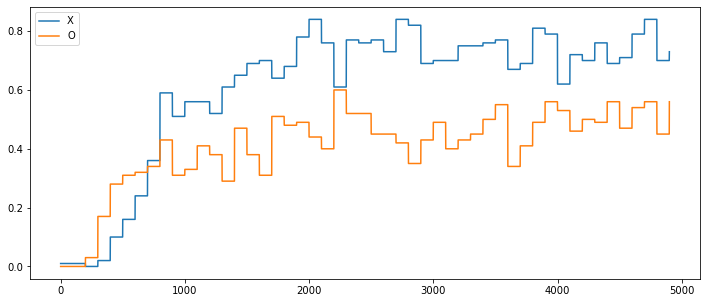

In [324]:
env = TicTacToeDQN(3,3,3, net=DQN, lr=1e-5, gamma=0.8)
learning_episodes = 5000
play_episodes = 100
crosses_mean_results = []
noughts_mean_results = []
crosses=[]
noughts=[]

for i in range(learning_episodes):
    env.run_episode(do_learning=True)
    if i % 100 == 0:
        crosses = env.playDQN(1,play_episodes)
        noughts = env.playDQN(-1,play_episodes)
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)
        plt.figure(figsize=(12, 5))
        plt.plot(crosses_mean_results, label='X')
        plt.plot(noughts_mean_results, label='O')
        plt.legend()
        plt.show()
        clear_output(wait=True)
    elif len(crosses)!=0:
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)

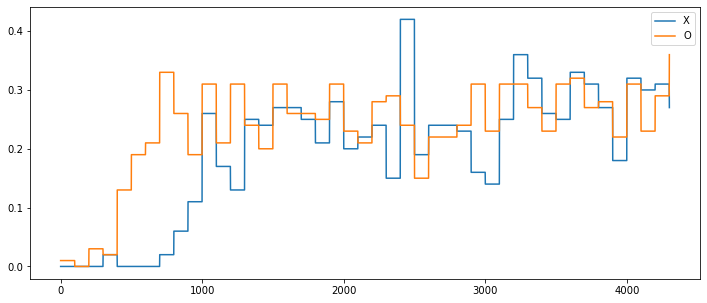

In [ ]:
env = TicTacToeDQN(4,4,4, net=DQN, lr=1e-5, gamma=0.8)
learning_episodes = 10000
play_episodes = 100
crosses_mean_results = []
noughts_mean_results = []
crosses=[]
noughts=[]

for i in range(learning_episodes):
    env.run_episode(do_learning=True)
    if i % 100 == 0:
        crosses = env.playDQN(1,play_episodes)
        noughts = env.playDQN(-1,play_episodes)
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)
        plt.figure(figsize=(12, 5))
        plt.plot(crosses_mean_results, label='X')
        plt.plot(noughts_mean_results, label='O')
        plt.legend()
        plt.show()
        clear_output(wait=True)
    elif len(crosses)!=0:
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)

Сохранение ноутбука начало шалить. В итоге вышел вот такой график

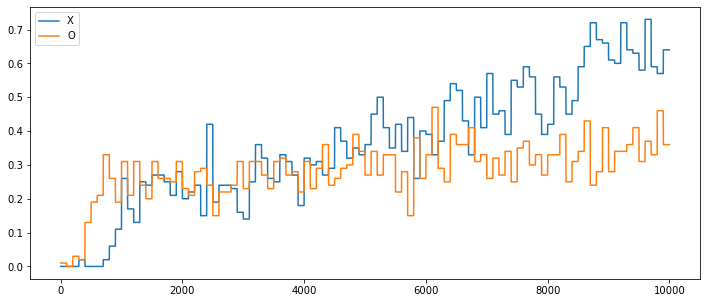

In [328]:
plt.figure(figsize=(12, 5))
plt.plot(crosses_mean_results, label='X')
plt.plot(noughts_mean_results, label='O')
plt.legend()
plt.show()

## Пункт 4. Dueling DQN

In [12]:
class DuelingDQN(nn.Module):
    def __init__(self, field_size=(3, 3), layer_size=512, hidden_dim=512):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=layer_size, kernel_size=field_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(layer_size, hidden_dim),
            nn.ReLU()
        ) 
        self.V_fc = nn.Linear(hidden_dim, 1)
        self.A_fc = nn.Linear(hidden_dim, field_size[0] * field_size[1])
        
    def forward(self, x):
        output = self.model(x)
        V = self.V_fc(output)
        A = self.A_fc(output)
        return V + (A - A.mean(1, keepdim=True))

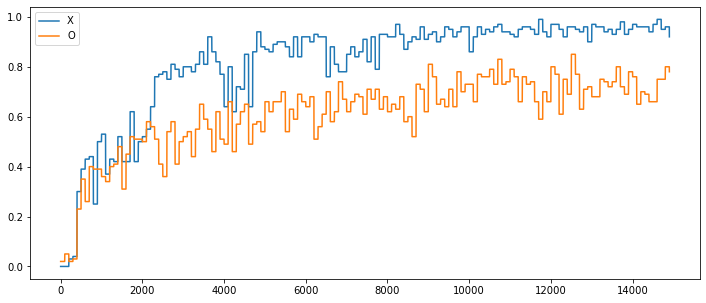

In [336]:
env = TicTacToeDQN(3,3,3, net=DuelingDQN, lr=1e-5, gamma=0.8)
learning_episodes = 15000
play_episodes = 100
crosses_mean_results = []
noughts_mean_results = []
crosses=[]
noughts=[]

for i in range(learning_episodes):
    env.run_episode(do_learning=True)
    if i % 100 == 0:
        crosses = env.playDQN(1,play_episodes)
        noughts = env.playDQN(-1,play_episodes)
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)
        plt.figure(figsize=(12, 5))
        plt.plot(crosses_mean_results, label='X')
        plt.plot(noughts_mean_results, label='O')
        plt.legend()
        plt.show()
        clear_output(wait=True)
    elif len(crosses)!=0:
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)

#### Учим 4х4

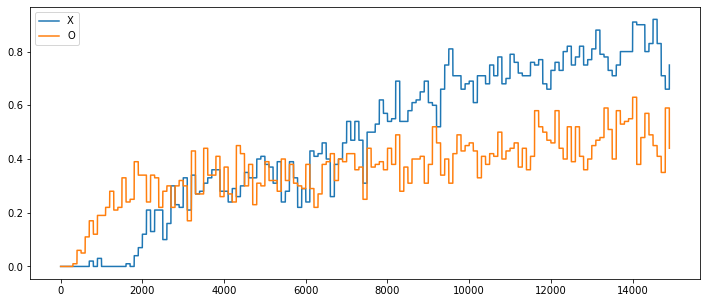

In [13]:
env = TicTacToeDQN(4, 4, 4, net=DuelingDQN, lr=1e-5, gamma=0.8)
learning_episodes = 15000
play_episodes = 100
crosses_mean_results = []
noughts_mean_results = []
crosses = []
noughts = []

for i in range(learning_episodes):
    env.run_episode(do_learning=True)
    if i % 100 == 0:
        crosses = env.playDQN(1,play_episodes)
        noughts = env.playDQN(-1,play_episodes)
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)
        plt.figure(figsize=(12, 5))
        plt.plot(crosses_mean_results, label='X')
        plt.plot(noughts_mean_results, label='O')
        plt.legend()
        plt.show()
        clear_output(wait=True)
    elif len(crosses)!=0:
        crosses_mean_results.append(np.sum(crosses[crosses==1])/play_episodes)
        noughts_mean_results.append(np.sum(noughts[noughts==1])/play_episodes)

# Часть 3.

## Пункт 5. Реализуем rollouts

In [92]:
def random_rollouts(env):
    env = copy.deepcopy(env)
    done = env.isTerminal() is not None
    while not done:
        action = random.choice(env.getEmptySpaces())
        _, reward, done, _ = env.step(action)
    return reward

In [27]:
rewards = []
env = TicTacToe()
for _ in range(100000):
    rewards.append(random_rollouts(env))

In [36]:
rewards = np.array(rewards)
print(f'O win: {(rewards == -1).sum() / len(rewards) * 100:.2f}%')
print(f'X win: {(rewards == 1).sum() / len(rewards) * 100:.2f}%')
print(f' Draw: {(rewards == 0).sum() / len(rewards) * 100:.2f}%')

O win: 28.90%
X win: 58.41%
 Draw: 12.69%


In [38]:
def first_rollouts(env, Q_X, Q_O):
    env = copy.deepcopy(env)
    done = env.isTerminal() is not None
    X_round = True
    while not done:
        if X_round:
            move, action = get_action(env, Q_X, epsilon=0.0)
        else:
            move, action = get_action(env, Q_O, epsilon=0.0)
        _, reward, done, _ = env.step(action)    
        X_round = not X_round
    return reward

In [39]:
rewards = []
env = TicTacToe()
for _ in range(100000):
    rewards.append(first_rollouts(env, Q_X, Q_O))  # Q-learning из 1 пункта

In [40]:
rewards = np.array(rewards)
print(f'O win: {(rewards == -1).sum() / len(rewards) * 100:.2f}%')
print(f'X win: {(rewards == 1).sum() / len(rewards) * 100:.2f}%')
print(f' Draw: {(rewards == 0).sum() / len(rewards) * 100:.2f}%')

O win: 0.00%
X win: 0.00%
 Draw: 100.00%


Обученные Q для X и для O играют в ничью в 100% случаев, звучит верно.

## Пункт 6. MCTS

In [99]:
class MCTS:
    def __init__(self, env):
        self.env = copy.deepcopy(env)
        self.parent = None
        self.term = False
        self.visited = False
        self.child = []
        self.reward, self.left, self.right = 0, 0, 0
        
    def search(self):
        if self.term:
            self.left += 1
            return -self.reward
        
        if not self.visited:
            self.visited = True
            self.reward = random_rollouts(self.env)
            self.right = (self.right * self.left + self.reward) / (self.left + 1)
            self.left += 1
            return self.reward
        
        if len(self.child) == 0:
            for action in self.env.getEmptySpaces():
                new_env = copy.deepcopy(env)
                _, rewards, done, _ = new_env.step(action)
                new_node = MCTS(new_env)
                new_node.parent = self 
                new_node.action = action
                self.child.append(new_node)
                if done:
                    new_node.term = True
                    new_node.reward = rewards
            val = self.child[0].search()
            self.right = (self.right * self.left + val) / (self.left + 1)
            self.left += 1
            return val

In [102]:
def move_mcts(env, actions):
    mcts = MCTS(env)
    for _ in range(1000):
        mcts.search()
    val = max(mcts.child, key=lambda x: x.left).action
    for index, i in enumerate(actions):
        if sum(i == val) == 2:
            return index
    return -1


def run_game_mcts(env):
    done = False
    env.reset()
    while not done:
        actions = env.getEmptySpaces()
        a = move_mcts(env, actions)
        observation, reward, done, _ = env.step(actions[a])
    return reward

In [103]:
rewards = []
for _ in tqdm(range(1000)):
    env = TicTacToe()
    rewards.append(run_game_mcts(env))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.34it/s]


In [104]:
rewards = np.array(rewards)
print(f'O win: {(rewards == -1).sum() / len(rewards) * 100:.2f}%')
print(f'X win: {(rewards == 1).sum() / len(rewards) * 100:.2f}%')
print(f' Draw: {(rewards == 0).sum() / len(rewards) * 100:.2f}%')

O win: 0.00%
X win: 100.00%
 Draw: 0.00%


MCTS обучился игре за X, за O нужно переписать функцию награды.  
MCTS обучение занимает намного меньше времени, по сравнению с DQN.